In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets,transforms,models
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import copy
import os
from PIL import Image

# FGSM on CNN using CIFAR10 dataset

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))])

train = datasets.CIFAR10(root = './data', train=True, transform = transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)

test = datasets.CIFAR10(root = './data', train=False, transform = transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=128,shuffle=True)


In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([3, 32, 32])
tensor([1, 0, 8, 9])


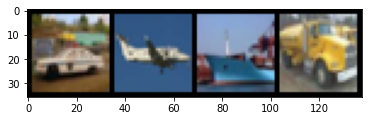

In [5]:
import torchvision

for images,labels in test_loader:
  break

print(images[0].shape)
imshow(torchvision.utils.make_grid(images[:4]))
print(labels[:4])

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.flat_shape =  128 * 8 * 8

    self.conv_block = torch.nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),


        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=1),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
        nn.MaxPool2d(2),
        nn.Flatten(start_dim=1)
    )

    self.dense_block = torch.nn.Sequential(
        nn.Linear(in_features=self.flat_shape, out_features=10),


        # torch.nn.Softmax(dim=1)
        )

  def forward(self, x):
    z = self.conv_block(x)
    output=self.dense_block(z)
    return output

In [7]:
model=CNN().cuda(device)
print(model)
optimiser=optim.Adam(model.parameters(),lr=0.001)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (dense_block): Sequential(
    (0): Linear(in_features=8192, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)


In [8]:
loss_function = nn.CrossEntropyLoss().cuda()

def train(epoch,model,optimiser):

  trainLoss=[]
  testLoss=[] 
  trainAcc=[]
  testAcc=[]
  model.train()
  for i in range(epoch):
    train_loss=0
    train_acc=0
    for batch_idx,(data,labels) in enumerate(train_loader):
      data=data.cuda()
      # print(data)
      labels = labels.cuda()
      # print(labels)
      optimiser.zero_grad()
      output=model(data)
      # print(output)
      # print("===========================================")
      
      loss=loss_function(output,labels)

      # print(loss)
      loss.backward()
      train_loss+=loss.item()

      optimiser.step()
      preds = torch.argmax(output, dim=1)
      train_acc += sum(preds.detach().cpu().numpy() == labels.detach().cpu().numpy())


      if batch_idx== 2860:
        print('Train Epoch:{} [{}/{} ({:.0f}%)]'.format(i+1,batch_idx*len(data),len(train_loader.dataset),100*batch_idx/len(train_loader)))
    

    print('======> Epoch :{} Train Loss : {:.6f}'.format(i+1,train_loss/len(train_loader.dataset)))
    trainLoss.append(train_loss/len(train_loader.dataset))

    train_acc = train_acc/len(train_loader.dataset)
    print("                  Train Accuracy: ",train_acc)
    trainAcc.append(train_acc)

    test_loss,test_acc=test(model)

    testLoss.append(test_loss)
    testAcc.append(test_acc)

  return model,trainLoss,testLoss,trainAcc,testAcc

def test(model):
  # model.eval()
  test_loss=0
  test_acc=0
  with torch.no_grad():
    for i,(data,labels) in enumerate(test_loader):

      data=data.cuda()
      labels = labels.cuda()
      output=model(data)

      loss=loss_function(output,labels)


      test_loss+=loss.item()

      preds = torch.argmax(output, dim=1)
      test_acc += sum(preds.detach().cpu().numpy() == labels.detach().cpu().numpy())

  test_loss/=len(test_loader.dataset)
  test_acc/=len(test_loader.dataset)

  print('=====> Test set loss : {:.6f}'.format(test_loss))
  print("       Test Accuracy: ",test_acc)
  return test_loss,test_acc

In [9]:
n_epochs=20

model,trL1,tsL1,trA1,tsA1=train(n_epochs,model,optimiser)
model

======> Epoch :1 Train Loss : 0.016179
                  Train Accuracy:  0.3844
=====> Test set loss : 0.000212
       Test Accuracy:  0.4587
======> Epoch :2 Train Loss : 0.015557
                  Train Accuracy:  0.46728
=====> Test set loss : 0.000187
       Test Accuracy:  0.4901
======> Epoch :3 Train Loss : 0.015251
                  Train Accuracy:  0.50728
=====> Test set loss : 0.000198
       Test Accuracy:  0.5314
======> Epoch :4 Train Loss : 0.014915
                  Train Accuracy:  0.55098
=====> Test set loss : 0.000209
       Test Accuracy:  0.5403
======> Epoch :5 Train Loss : 0.014693
                  Train Accuracy:  0.58002
=====> Test set loss : 0.000189
       Test Accuracy:  0.5542
======> Epoch :6 Train Loss : 0.014485
                  Train Accuracy:  0.6072
=====> Test set loss : 0.000196
       Test Accuracy:  0.5985
======> Epoch :7 Train Loss : 0.014326
                  Train Accuracy:  0.62742
=====> Test set loss : 0.000176
       Test Accuracy:  0

CNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (dense_block): Sequential(
    (0): Linear(in_features=8192, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

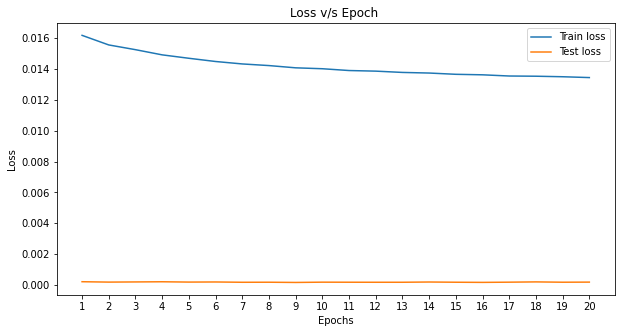

In [45]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]

plt.plot(epochArr,trL1)
plt.plot(epochArr,tsL1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch ")
plt.legend(["Train loss","Test loss"])
plt.show()

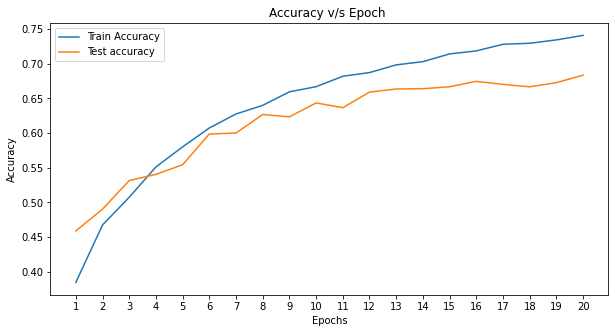

In [46]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trA1)
plt.plot(epochArr,tsA1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epoch ")
plt.legend(["Train Accuracy","Test accuracy"])
plt.show()

In [10]:
def FGSM(model,data,labels,ep=0.01):
  data=data.cuda()
  # print(data)
  labels = labels.cuda()
  # print(labels)
  data.requires_grad = True
  output=model(data)
  # print(output)
  loss=loss_function(output,labels)
  # print(loss)
  loss.backward()
  data_grad = data.grad.data
  # print(data_grad)
  sign_data_grad = data_grad.sign()
  # print(sign_data_grad)
  data = data + ep*sign_data_grad
  # print(data)
  perturbed_image = torch.clamp(data, 0, 1)
  return perturbed_image


what percent of labels got wrongly predicted after perturbation

In [12]:
eps=[0,0.01,0.025,0.05,0.075,0.1,0.2]
for ep in eps:
  correct=0
  for images,labels in test_loader:
    labels=labels.cuda()
    perturbed_images=FGSM(model,images,labels,ep=ep)

    per_preds=model(perturbed_images)

    per_preds=torch.argmax(per_preds, dim=1)

    correct += ((labels==per_preds).sum())
  acc = correct/len(test_loader.dataset)
  print("Epsilon: ",ep,"  Changes the classes for (%): ", (1.0-acc)*100.0)

Epsilon:  0   Changes the classes for (%):  tensor(31.6600, device='cuda:0')
Epsilon:  0.01   Changes the classes for (%):  tensor(63.5900, device='cuda:0')
Epsilon:  0.025   Changes the classes for (%):  tensor(84.5800, device='cuda:0')
Epsilon:  0.05   Changes the classes for (%):  tensor(96.2800, device='cuda:0')
Epsilon:  0.075   Changes the classes for (%):  tensor(98.4100, device='cuda:0')
Epsilon:  0.1   Changes the classes for (%):  tensor(98.6800, device='cuda:0')
Epsilon:  0.2   Changes the classes for (%):  tensor(98.0100, device='cuda:0')


Success rate means  how good is our attack in changing the resultant class given by the classifier into some other class

In [13]:
eps=[0,0.01,0.025,0.05,0.075,0.1,0.2]
for ep in eps:
  correct=0
  for images,labels in test_loader:
    perturbed_images=FGSM(model,images,labels,ep=ep)

    # print(perturbed_images[0].shape)

    o_preds=model(images.cuda())
    per_preds=model(perturbed_images)
    o_preds= torch.argmax(o_preds, dim=1)
    per_preds=torch.argmax(per_preds, dim=1)
    correct += ((o_preds==per_preds).sum())
  acc = correct/len(test_loader.dataset)
  print("Epsilon: ",ep,"  Success Rate: ", (1.0-acc)*100.0)

Epsilon:  0   Success Rate:  tensor(0., device='cuda:0')
Epsilon:  0.01   Success Rate:  tensor(31.9700, device='cuda:0')
Epsilon:  0.025   Success Rate:  tensor(52.9700, device='cuda:0')
Epsilon:  0.05   Success Rate:  tensor(65.1500, device='cuda:0')
Epsilon:  0.075   Success Rate:  tensor(68.1900, device='cuda:0')
Epsilon:  0.1   Success Rate:  tensor(69.5300, device='cuda:0')
Epsilon:  0.2   Success Rate:  tensor(72.9000, device='cuda:0')


# PGD

In [26]:


dataset = datasets.SVHN(root='data/', download=True, transform=transforms.ToTensor())
test_size = 12000
train_size = len(dataset) - test_size
# print(len(dataset))

train2, test2 = random_split(dataset, [train_size, test_size])
len(train2), len(test2)

train_loader2 = torch.utils.data.DataLoader(train2, batch_size=128, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test2, batch_size=128, shuffle=True)




Using downloaded and verified file: data/train_32x32.mat


torch.Size([3, 32, 32])
tensor([1, 5, 0, 8])


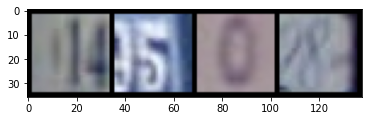

In [27]:
import torchvision

for images,labels in test_loader2:
  break

print(images[0].shape)
imshow(torchvision.utils.make_grid(images[:4]))
print(labels[:4])

In [28]:
def getModel_res():
  # Load the pre-trained ResNet18 model
  model = models.resnet18(pretrained=True)

  # Freeze the pre-trained layers
  for param in model.parameters():
      param.requires_grad = False

  # Replace the last fully connected layer to fit our task
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 10) # 10 classes in STL10
  return model

model2=getModel_res().cuda(device)

optimiser2 = optim.Adam(model2.fc.parameters(), lr=0.001)
model2,trainLoss2,testLoss2,trainAcc2,testAcc2=train(20,model2,optimiser2)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


======> Epoch :1 Train Loss : 0.013882
                  Train Accuracy:  0.38478
=====> Test set loss : 0.000238
       Test Accuracy:  0.431
======> Epoch :2 Train Loss : 0.012547
                  Train Accuracy:  0.444
=====> Test set loss : 0.000150
       Test Accuracy:  0.4307
======> Epoch :3 Train Loss : 0.012350
                  Train Accuracy:  0.45284
=====> Test set loss : 0.000202
       Test Accuracy:  0.4496
======> Epoch :4 Train Loss : 0.012232
                  Train Accuracy:  0.45778
=====> Test set loss : 0.000202
       Test Accuracy:  0.4488
======> Epoch :5 Train Loss : 0.012190
                  Train Accuracy:  0.45836
=====> Test set loss : 0.000143
       Test Accuracy:  0.4494
======> Epoch :6 Train Loss : 0.012119
                  Train Accuracy:  0.46272
=====> Test set loss : 0.000181
       Test Accuracy:  0.4507
======> Epoch :7 Train Loss : 0.012130
                  Train Accuracy:  0.46254
=====> Test set loss : 0.000196
       Test Accuracy:  0.

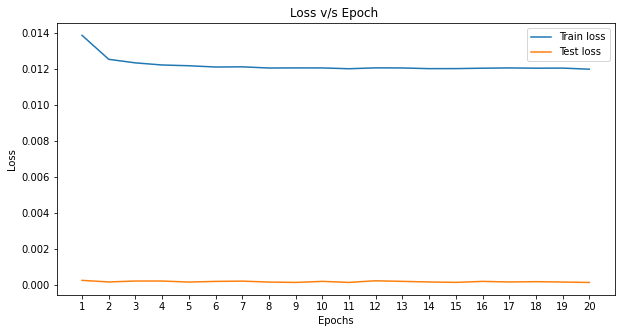

In [47]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]

plt.plot(epochArr,trainLoss2)
plt.plot(epochArr,testLoss2)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch ")
plt.legend(["Train loss","Test loss"])
plt.show()

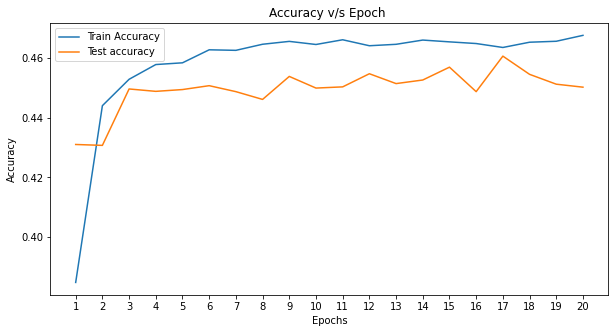

In [48]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trainAcc2)
plt.plot(epochArr,testAcc2)

plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epoch ")
plt.legend(["Train Accuracy","Test accuracy"])
plt.show()

In [29]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

what percent of labels got wrongly predicted after perturbation

In [30]:
eps=[0,0.01,0.025,0.05,0.075,0.1,0.2]
for ep in eps:
  correct=0
  for images,labels in test_loader2:
    labels=labels.cuda()
    perturbed_images=pgd_attack(model2,images,labels,eps=ep)

    per_preds=model2(perturbed_images)

    per_preds=torch.argmax(per_preds, dim=1)

    correct += ((labels==per_preds).sum())
  acc = correct/len(test_loader2.dataset)
  print("Epsilon: ",ep,"  Changes the classes for (%): ", (1.0-acc)*100.0)

Epsilon:  0   Changes the classes for (%):  tensor(89.8083, device='cuda:0')
Epsilon:  0.01   Changes the classes for (%):  tensor(99.2917, device='cuda:0')
Epsilon:  0.025   Changes the classes for (%):  tensor(99.9417, device='cuda:0')
Epsilon:  0.05   Changes the classes for (%):  tensor(100., device='cuda:0')
Epsilon:  0.075   Changes the classes for (%):  tensor(100., device='cuda:0')
Epsilon:  0.1   Changes the classes for (%):  tensor(100., device='cuda:0')
Epsilon:  0.2   Changes the classes for (%):  tensor(100., device='cuda:0')


Success rate means  how good is our attack in changing the resultant class given by the classifier into some other class

In [31]:
eps=[0,0.01,0.025,0.05,0.075,0.1,0.2]

for ep in eps:
  correct=0
  for images,labels in test_loader2:
      perturbed_images=pgd_attack(model2,images,labels,eps=ep)

      # print(perturbed_images[0].shape)

      o_preds=model2(images.cuda())
      per_preds=model2(perturbed_images)
      o_preds= torch.argmax(o_preds, dim=1)
      per_preds=torch.argmax(per_preds, dim=1)
      # print((o_preds==per_preds).sum())
      correct += ((o_preds==per_preds).sum())

  acc = correct/len(test_loader2.dataset)

  print("Epsilon: ",ep,"  Success Rate: ", (1.0-acc)*100.0)

Epsilon:  0   Success Rate:  tensor(0., device='cuda:0')
Epsilon:  0.01   Success Rate:  tensor(63.3167, device='cuda:0')
Epsilon:  0.025   Success Rate:  tensor(71.2000, device='cuda:0')
Epsilon:  0.05   Success Rate:  tensor(73.9500, device='cuda:0')
Epsilon:  0.075   Success Rate:  tensor(74.2583, device='cuda:0')
Epsilon:  0.1   Success Rate:  tensor(73.5083, device='cuda:0')
Epsilon:  0.2   Success Rate:  tensor(73.8750, device='cuda:0')


In [32]:
def getModel_vgg():
  # Load the pre-trained Inception_v3 model
  model = models.vgg16(pretrained=True)

  # Freeze the pre-trained layers
  for param in model.parameters():
      param.requires_grad = False

  # Replace the last fully connected layer to fit our task
  num_ftrs = model.classifier[-1].in_features
  model.classifier[-1] = nn.Linear(num_ftrs,10)

  return model



In [33]:
model3=getModel_vgg().cuda(device)

optimiser3 = optim.Adam(model3.parameters(), lr=0.001)
model3,trainLoss3,testLoss3,trainAcc3,testAcc3=train(20,model3,optimiser3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

======> Epoch :1 Train Loss : 0.011708
                  Train Accuracy:  0.47916
=====> Test set loss : 0.000125
       Test Accuracy:  0.501
======> Epoch :2 Train Loss : 0.011187
                  Train Accuracy:  0.50764
=====> Test set loss : 0.000171
       Test Accuracy:  0.4985
======> Epoch :3 Train Loss : 0.011251
                  Train Accuracy:  0.50738
=====> Test set loss : 0.000187
       Test Accuracy:  0.4942
======> Epoch :4 Train Loss : 0.011210
                  Train Accuracy:  0.5122
=====> Test set loss : 0.000186
       Test Accuracy:  0.5024
======> Epoch :5 Train Loss : 0.011266
                  Train Accuracy:  0.51134
=====> Test set loss : 0.000137
       Test Accuracy:  0.5088
======> Epoch :6 Train Loss : 0.011219
                  Train Accuracy:  0.516
=====> Test set loss : 0.000120
       Test Accuracy:  0.4988
======> Epoch :7 Train Loss : 0.011276
                  Train Accuracy:  0.51222
=====> Test set loss : 0.000091
       Test Accuracy:  0.5

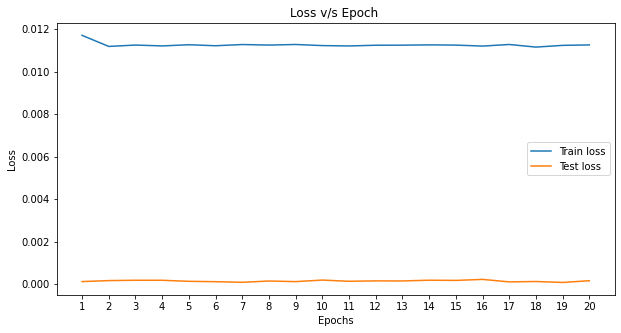

In [49]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]

plt.plot(epochArr,trainLoss3)
plt.plot(epochArr,testLoss3)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch ")
plt.legend(["Train loss","Test loss"])
plt.show()

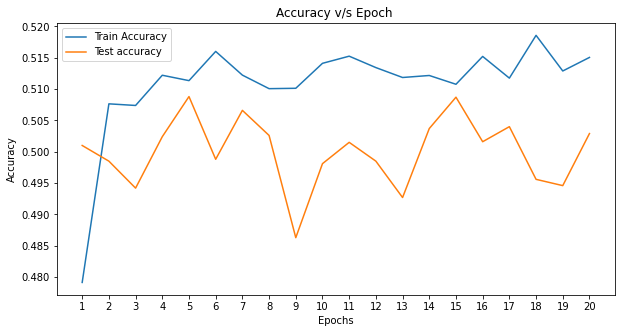

In [50]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trainAcc3)
plt.plot(epochArr,testAcc3)

plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epoch ")
plt.legend(["Train Accuracy","Test accuracy"])
plt.show()

what percent of labels got wrongly predicted after perturbation

In [35]:
eps=[0,0.01,0.025,0.05,0.075,0.1,0.2]
for ep in eps:
  correct=0
  for images,labels in test_loader2:
    labels=labels.cuda()
    perturbed_images=pgd_attack(model3,images,labels,eps=ep)

    per_preds=model3(perturbed_images)

    per_preds=torch.argmax(per_preds, dim=1)

    correct += ((labels==per_preds).sum())
  acc = correct/len(test_loader2.dataset)
  print("Epsilon: ",ep,"  Changes the classes for (%): ", (1.0-acc)*100.0)

Epsilon:  0   Changes the classes for (%):  tensor(88.9833, device='cuda:0')
Epsilon:  0.01   Changes the classes for (%):  tensor(98.5917, device='cuda:0')
Epsilon:  0.025   Changes the classes for (%):  tensor(99.8750, device='cuda:0')
Epsilon:  0.05   Changes the classes for (%):  tensor(99.9667, device='cuda:0')
Epsilon:  0.075   Changes the classes for (%):  tensor(99.9833, device='cuda:0')
Epsilon:  0.1   Changes the classes for (%):  tensor(99.9917, device='cuda:0')
Epsilon:  0.2   Changes the classes for (%):  tensor(100., device='cuda:0')


Success rate means  how good is our attack in changing the resultant class given by the classifier into some other class

In [37]:
eps=[0,0.01,0.025,0.05,0.075,0.1,0.2]

for ep in eps:
  correct=0
  for images,labels in test_loader2:
      perturbed_images=pgd_attack(model3,images,labels,eps=ep)

      # print(perturbed_images[0].shape)

      o_preds=model3(images.cuda())
      per_preds=model3(perturbed_images)
      o_preds= torch.argmax(o_preds, dim=1)
      per_preds=torch.argmax(per_preds, dim=1)
      # print((o_preds==per_preds).sum())
      correct += ((o_preds==per_preds).sum())

  acc = correct/len(test_loader2.dataset)

  print("Epsilon: ",ep,"  Success Rate: ", (1.0-acc)*100.0)

Epsilon:  0   Success Rate:  tensor(58.2250, device='cuda:0')
Epsilon:  0.01   Success Rate:  tensor(66.7250, device='cuda:0')
Epsilon:  0.025   Success Rate:  tensor(74.6333, device='cuda:0')
Epsilon:  0.05   Success Rate:  tensor(77.1417, device='cuda:0')
Epsilon:  0.075   Success Rate:  tensor(78.2917, device='cuda:0')
Epsilon:  0.1   Success Rate:  tensor(78.8750, device='cuda:0')
Epsilon:  0.2   Success Rate:  tensor(79.0583, device='cuda:0')
